In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [2]:
splits = ['random', 'scaffold', 'protein']
datasets = ['pdbbind']
tasks = ['all', 'easy', 'hard']
results_dir = 'results/'
iterations = range(5)

In [8]:
from rdkit.ML.Scoring.Scoring import CalcAUC
scores = [(1, True),
          (2, False),
          (3, True),
          (4, True)]
CalcAUC(scores, 1)

0.3333333333333333

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
y = [int(score[1]) for score in scores]
scores = [score[0] for score in scores]
fpr, tpr, thresholds = roc_curve(y, scores)

In [10]:
tpr

array([0.        , 0.33333333, 0.66666667, 0.66666667, 1.        ])

In [13]:
roc_auc_score(y, scores)

0.6666666666666666

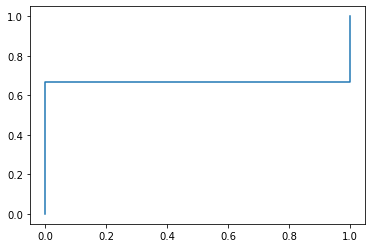

In [6]:
plt.plot(fpr, tpr)

In [7]:
bioactive_accuracy_df = pd.DataFrame()
regression_df = pd.DataFrame()
ranking_df = pd.DataFrame()

In [8]:
for split in splits :

    for iteration in iterations[:2] :
        
        for dataset in datasets :
            
            experiment_name = f'{split}_split_{iteration}'
            evaluation_name = f'{experiment_name}_{dataset}'
            
            working_dir = os.path.join(results_dir, evaluation_name)
            for task in tasks :
                dataset_results_path = os.path.join(working_dir, f'dataset_results_{task}.p')
                with open(dataset_results_path, 'rb') as f:
                    dataset_results = pickle.load(f)

                for ranker in ['model', 'energy', 'random'] :
                    dataset_results['bioactive_accuracy'][ranker]['split'] = split
                    dataset_results['bioactive_accuracy'][ranker]['dataset'] = dataset
                    dataset_results['bioactive_accuracy'][ranker]['task'] = task
                    dataset_results['bioactive_accuracy'][ranker]['ranker'] = ranker
                    bioactive_accuracy_df = bioactive_accuracy_df.append(pd.Series(dataset_results['bioactive_accuracy'][ranker]), ignore_index=True)

                for average_type in dataset_results['regression'] :
                    dataset_results['regression'][average_type]['split'] = split
                    dataset_results['regression'][average_type]['dataset'] = dataset
                    dataset_results['regression'][average_type]['task'] = task
                    dataset_results['regression'][average_type]['average_type'] = average_type
                    regression_df = regression_df.append(pd.Series(dataset_results['regression'][average_type]), ignore_index=True)

                for ranker in dataset_results['ranking'] :
                    dataset_results['ranking'][ranker]['split'] = split
                    dataset_results['ranking'][ranker]['dataset'] = dataset
                    dataset_results['ranking'][ranker]['task'] = task
                    dataset_results['ranking'][ranker]['ranker'] = ranker
                    ranking_df = ranking_df.append(pd.Series(dataset_results['ranking'][ranker]), ignore_index=True)

In [9]:
correct_dataset_name = {
    'pdbbind' : 'PDBBind',
    'platinum' : 'Platinum'
}

# Regression

In [10]:
regression_df['subset'] = regression_df['task']

In [11]:
regression_df.head()

,average_type,dataset,pearson_all,pearson_gen,r2_all,r2_gen,rmse_all,rmse_bio,rmse_gen,spearman_all,spearman_gen,split,task,subset
0,Micro,pdbbind,0.791997,0.787867,0.620234,0.608756,0.611596,0.702219,0.600809,0.767256,0.761875,random,all,all
1,Macro,pdbbind,0.432718,0.398173,-0.794725,-8.354525,0.519719,1.002221,0.499429,0.395610,0.375584,random,all,all
2,Micro,pdbbind,0.692139,0.669122,0.456580,0.408660,0.504870,0.503167,0.489435,0.666409,0.636318,random,easy,easy
3,Macro,pdbbind,0.359185,0.319404,-1.965725,-24.652521,0.442199,0.705677,0.408111,0.336721,0.298829,random,easy,easy
4,Micro,pdbbind,0.776761,0.774520,0.593193,0.584878,0.624767,0.814602,0.613781,0.749696,0.746444,random,hard,hard


In [12]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [13]:
rmselabel = 'Mean RMSE'
r2label = 'R2'
new_data = regression_df[(regression_df['dataset'] == dataset) 
                         & (regression_df['average_type'] == 'Micro') 
                         & (regression_df['task'] == 'all')]
all_data = new_data[['split', 'rmse_all', 'r2_all']]
all_data = all_data.rename({'rmse_all' : rmselabel, 'r2_all' : r2label}, axis=1)
all_data['Conformation subset'] = 'All'
gen_data = new_data[['split', 'rmse_gen', 'r2_gen']]
gen_data = gen_data.rename({'rmse_gen' : rmselabel, 'r2_gen' : r2label}, axis=1)
gen_data['Conformation subset'] = 'Generated'
bio_data = new_data[['split', 'rmse_bio']]
bio_data = bio_data.rename({'rmse_bio' : rmselabel}, axis=1)
bio_data['Conformation subset'] = 'Bioactive'
merged_data = pd.concat([all_data, gen_data, bio_data])

grouped_data = merged_data.groupby(['Conformation subset', 'split'], sort=False).agg({rmselabel : [custom_agg],
                                                                                     r2label : [custom_agg]})
grouped_data = grouped_data.unstack(0)
grouped_data = grouped_data.droplevel(1, axis=1)
grouped_data.index.name = 'Split'
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
grouped_data = grouped_data.swaplevel(axis=1)
grouped_data = grouped_data.sort_index(axis=1)

In [14]:
grouped_data

Conformation subset          All                 Bioactive        Generated  \
                       Mean RMSE           R2    Mean RMSE  R2    Mean RMSE   
Split                                                                         
Random                0.6 ± 0.01  0.61 ± 0.01   0.8 ± 0.14  NA  0.59 ± 0.01   
Scaffold             0.66 ± 0.01  0.49 ± 0.01   1.3 ± 0.06  NA  0.64 ± 0.01   
Protein              0.67 ± 0.02   0.49 ± 0.0  1.35 ± 0.03  NA  0.65 ± 0.02   

Conformation subset               
                              R2  
Split                             
Random                0.6 ± 0.01  
Scaffold             0.49 ± 0.01  
Protein                0.5 ± 0.0

# Bioactive conformation identification

In [15]:
bioactive_accuracy_df['subset'] = bioactive_accuracy_df['task']

In [16]:
bioactive_accuracy_df['ranker'] = bioactive_accuracy_df['ranker'].replace({'model' : 'BioSchNet',
                                                                          'energy' : 'UFF energy',
                                                                          'random' : 'Random'})

In [17]:
bioactive_accuracy_df.head()

,dataset,mean_top1_accuracy,median_all_bioactive,median_min_bioactive,median_normalized_bioactive,q1_all_bioactive,q1_min_bioactive,q1_normalized_bioactive,q3_all_bioactive,q3_min_bioactive,q3_normalized_bioactive,ranker,split,task,subset
0,pdbbind,0.432782,3.0,1.0,0.029703,0.0,0.0,0.000000,12.0,13.0,0.288564,BioSchNet,random,all,all
1,pdbbind,0.212078,22.0,18.0,0.356436,4.0,2.0,0.039604,75.0,68.5,0.772277,UFF energy,random,all,all
2,pdbbind,0.049605,33.0,26.0,0.415842,10.0,7.0,0.178218,66.0,58.0,0.665017,Random,random,all,all
3,pdbbind,0.389868,3.0,1.0,0.108187,1.0,0.0,0.000000,10.0,6.0,0.403998,BioSchNet,random,easy,easy
4,pdbbind,0.301762,6.0,3.0,0.250000,2.0,0.0,0.000000,19.0,9.0,0.614316,UFF energy,random,easy,easy


In [18]:
ratiolabel = 'Ratio of molecules with bioactive ranked first'
ranklabel = 'Median normalized rank of bioactive conformation'
new_data = bioactive_accuracy_df[(bioactive_accuracy_df['dataset'] == dataset) 
                         & (bioactive_accuracy_df['task'] == task)]
new_data = new_data.rename({'mean_top1_accuracy' : ratiolabel,
                           'median_normalized_bioactive' : ranklabel}, axis=1)

grouped_data = new_data.groupby(['split', 'ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})
#grouped_data = grouped_data.rename({name[1] : name[1].capitalize() for name in grouped_data.columns}, axis=1, level=1)

In [19]:
grouped_data

Ratio of molecules with bioactive ranked first               \
Ranker                                        BioSchNet   UFF energy   
Split                                                                  
Random                                      0.42 ± 0.05   0.17 ± 0.0   
Scaffold                                    0.25 ± 0.04   0.14 ± 0.0   
Protein                                     0.16 ± 0.01  0.15 ± 0.01   

                      Median normalized rank of bioactive conformation  \
Ranker         Random                                        BioSchNet   
Split                                                                    
Random    0.01 ± 0.01                                      0.02 ± 0.01   
Scaffold   0.01 ± 0.0                                       0.1 ± 0.04   
Protein    0.01 ± 0.0                                      0.23 ± 0.01   

                                    
Ranker     UFF energy       Random  
Split                               
Random    0.45 ± 0.01  0.44 ± 0.01  
Scaffold  0.48 ± 0.01   0.47 ± 0.0  
Protein    0.5 ± 0.08  0.49 ± 0.01

# Ranking

In [20]:
ranking_df['subset'] = ranking_df['task']

In [21]:
ranking_df.head()

,bedroc,dataset,ef_0.01,ef_0.02,ef_0.03,ef_0.04,ef_0.05,ef_0.06,ef_0.07,ef_0.08,...,normalized_ef_0.95,normalized_ef_0.96,normalized_ef_0.97,normalized_ef_0.98,normalized_ef_0.99,normalized_ef_1.0,ranker,split,task,subset
0,0.341040,pdbbind,1.091333,1.028181,1.006382,1.036490,1.028078,1.034294,0.996356,0.989690,...,0.332093,0.332080,0.332078,0.332212,0.332083,0.332136,random,random,all,all
1,0.399145,pdbbind,1.437077,1.501719,1.373985,1.330023,1.320237,1.282953,1.259048,1.260507,...,0.333475,0.333057,0.332841,0.332568,0.332388,0.332136,energy,random,all,all
2,0.403042,pdbbind,1.306157,1.277366,1.244438,1.199303,1.242182,1.203987,1.196499,1.191798,...,0.333180,0.332938,0.332805,0.332470,0.332254,0.332136,ccdc,random,all,all
3,0.551174,pdbbind,3.642295,3.453276,3.216138,3.047103,2.960510,2.784393,2.585626,2.579977,...,0.336603,0.335342,0.334634,0.333647,0.332782,0.332136,model,random,all,all
4,0.607132,pdbbind,1.042288,1.006048,0.970417,0.964303,0.971785,0.993358,0.974208,0.978201,...,NaN,NaN,NaN,NaN,NaN,NaN,random,random,easy,easy


In [22]:
def custom_ranker_order(series) :
    d = {'BioSchNet' : 0,
         'CCDC' : 1,
         'UFF energy' : 2,
         'Random' : 3}
    return [d[s] for s in series]

In [23]:
def custom_split_order(series) :
    d = {'Random' : 0,
         'Scaffold' : 1,
         'Protein' : 2}
    return [d[s] for s in series]

In [24]:
ylabel = 'Mean EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [25]:
grouped_data

Mean EF at fraction = 0.1                                       
Ranker                   BioSchNet         CCDC   UFF energy       Random
Split                                                                    
Random                 2.34 ± 0.15  1.17 ± 0.01  1.27 ± 0.03  0.99 ± 0.03
Scaffold               1.91 ± 0.05   1.2 ± 0.01   1.28 ± 0.0  0.98 ± 0.02
Protein                 1.51 ± 0.1  1.17 ± 0.04  1.24 ± 0.02  1.03 ± 0.01

In [26]:
ylabel = 'Mean normalized EF at fraction = 0.1'
new_data = ranking_df[(ranking_df['task'] == 'all')]
new_data = new_data.rename({'normalized_ef_0.1' : ylabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')

new_data['Split'] = new_data['split'].replace({name : name.capitalize() for name in new_data['split'].unique()})
#new_data = new_data.sort_values(by='Split', key=lambda s: custom_split_order(s))

grouped_data = new_data.groupby(['Split', 'Ranker'], sort=False).agg({ylabel : custom_agg})
grouped_data = grouped_data.unstack(1)

In [27]:
grouped_data

Mean normalized EF at fraction = 0.1                          \
Ranker                              BioSchNet        CCDC  UFF energy   
Split                                                                   
Random                             0.49 ± 0.0  0.38 ± 0.0  0.38 ± 0.0   
Scaffold                                  0.4        0.35        0.34   
Protein                                  0.45        0.43        0.42   

                       
Ranker         Random  
Split                  
Random    0.33 ± 0.01  
Scaffold         0.31  
Protein          0.38

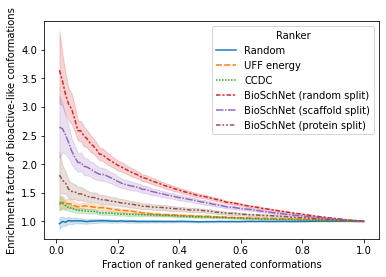

In [28]:
dataset = 'pdbbind'
df = pd.DataFrame()
xlabel = 'Fraction of ranked generated conformations'
ylabel = 'Enrichment factor of bioactive-like conformations'
for split in splits :
    evaluation_name = f'{split}_split_0_{dataset}'
    ef_df_path = os.path.join('results/',
                             evaluation_name,
                             'ef_df.csv')
    ef_df = pd.read_csv(ef_df_path, index_col=0)
    ef_df['ranker'] = ef_df['ranker'].replace({'model' : f'model_{split}'})
    ef_df = ef_df.rename({'Fraction' : xlabel,
                          'Enrichment factor' : ylabel}, axis=1)
    df = df.append(ef_df, ignore_index=True)

df['Ranker'] = df['ranker'].replace({'random' : 'Random',
                                     'energy' : 'UFF energy',
                                     'ccdc' : 'CCDC',
                                     'model_random' : 'BioSchNet (random split)',
                                     'model_scaffold' : 'BioSchNet (scaffold split)',
                                     'model_protein' : 'BioSchNet (protein split)'})
    
sns.lineplot(data=df, x=xlabel, y=ylabel, hue='Ranker', style='Ranker')
#plt.title(f'Generated conformation ranking evaluation ({dataset})')
plt.xlabel('Fraction of ranked generated conformations')
fig_path = os.path.join('figures/', 
                        f'efs_{dataset}.png')
plt.savefig(fig_path, dpi=300)
plt.show()

# Rigid ligand docking

In [47]:
df = pd.DataFrame()
for split in splits :
    evaluation_name = f'{split}_split_0_pdbbind'
    recall_df_path = os.path.join('results/',
                             evaluation_name,
                             'rigid_ligand_docking_recall_successful_only.csv')
    recall_df = pd.read_csv(recall_df_path, index_col=0)
    recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
    df = df.append(recall_df, ignore_index=True)

In [48]:
df['Number of input conformations'] = df['Number of input conformations'] + 1

In [49]:
df[(df['Number of input conformations'] == 20) & (df['metric'] == 'ligand_rmsd')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

Recall          
                    mean       std
ranker                            
CCDC            0.195258  0.025919
energy          0.292632  0.020255
model_protein   0.313725       NaN
model_random    0.586085       NaN
model_scaffold  0.467505       NaN
random          0.203018  0.020399
score           0.735033  0.075379

In [50]:
df['metric'].unique()

array(['score', 'ligand_rmsd', 'overlay_rmsd', 'docking_power',
       'correct_conf'], dtype=object)

In [51]:
metric = 'ligand_rmsd'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of best pose'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [52]:
metric = 'ligand_rmsd'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of best pose'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.xlim(0, 20)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking_truncated.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [53]:
flexible_docking_powers = {
    'random' : 0.68,
    'scaffold' : 0.57,
    'protein' : 0.63
}

generation_powers = {
    'random' : 0.76,
    'scaffold' : 0.70,
    'protein' : 0.79
}

In [54]:
splits = ['random', 'scaffold', 'protein']
df = pd.DataFrame()
for split in splits :
    evaluation_name = f'{split}_split_0_pdbbind'
    recall_df_path = os.path.join('results/',
                             evaluation_name,
                             'rigid_ligand_docking_recall_all.csv')
    recall_df = pd.read_csv(recall_df_path, index_col=0)
    recall_df['Number of input conformations'] = recall_df['Number of input conformations'] + 1
    recall_df['ranker'] = recall_df['ranker'].replace({'model' : f'model_{split}'})
    flexible_docking_power = flexible_docking_powers[split]
    print(recall_df[(recall_df['Recall'] >= flexible_docking_power) 
              & (recall_df['metric'] == 'docking_power')].drop_duplicates(subset='ranker'))
    df = df.append(recall_df, ignore_index=True)

      Number of input conformations    Recall         metric        ranker
1511                             12  0.688508  docking_power  model_random
1638                             39  0.683468  docking_power        energy
1706                              7  0.684476  docking_power         score
1824                             25  0.681452  docking_power        random
1930                             31  0.681452  docking_power          CCDC
      Number of input conformations    Recall         metric          ranker
1506                              7  0.580292  docking_power  model_scaffold
1611                             12  0.574818  docking_power          energy
1700                              1  0.609489  docking_power           score
1808                              9  0.582117  docking_power          random
1910                             11  0.574818  docking_power            CCDC
      Number of input conformations    Recall         metric         ranker
1518        

In [55]:
df[(df['Number of input conformations'] == 100) & (df['metric'] == 'docking_power')].groupby('ranker').agg({'Recall' : ['mean', 'std']})

Recall          
                    mean       std
ranker                            
CCDC            0.817914  0.011537
energy          0.817914  0.011537
model_protein   0.815991       NaN
model_random    0.807460       NaN
model_scaffold  0.830292       NaN
random          0.817914  0.011537
score           0.817914  0.011537

In [56]:
# Docking power 60%
df[(df['Recall'] >= 0.60) & (df['metric'] == 'docking_power')].drop_duplicates(subset='ranker')# .groupby('ranker').agg({'Conformation rank' : ['mean', 'std']})

,Number of input conformations,Recall,metric,ranker
1504,5,0.600806,docking_power,model_random
1621,22,0.607863,docking_power,energy
1702,3,0.619960,docking_power,score
1813,14,0.602823,docking_power,random
1916,17,0.610887,docking_power,CCDC
4007,8,0.600365,docking_power,model_scaffold
6514,15,0.602410,docking_power,model_protein


In [57]:
metric = 'docking_power'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of best pose'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.ylim(0,1)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking.png')
plt.savefig(fig_path, dpi=300)
plt.close()

In [58]:
metric = 'docking_power'
metric_df = df[df['metric'] == metric]
sns.lineplot(data=metric_df, x='Number of input conformations', y=f'Recall', hue='ranker')

if metric == 'docking_power' :
    title = 'Docking power'
elif metric == 'ligand_rmsd' :
    title = 'Retrieval of best pose'
else :
    title = f'Retrieval of top {metric}'

plt.title(title)
plt.xlim(0, 20)
fig_path = os.path.join('figures/', 
                        f'{metric}_rigid_docking_truncated.png')
plt.savefig(fig_path, dpi=300)
plt.close()